In [8]:
# 线性回归与k最近邻
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt
covidtotals = pd.read_csv('C:\dataClean\Python-Data-Cleaning-Cookbook\Chapter04\data\covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)

In [9]:
xvars = ['pop_density', 'median_age', 'gdp_per_capita']
covidanalysis = covidtotals.loc[:, ['total_cases_pm']+xvars].dropna()           # dropna删除包含任何缺失列的行
covidanalysis.describe()

,total_cases_pm,pop_density,median_age,gdp_per_capita
count,175.000000,175.000000,175.000000,175.000000
mean,1134.015709,247.151863,30.537143,19008.385423
std,2101.363772,822.398967,9.117751,19673.386571
min,0.000000,1.980000,15.100000,661.240000
25%,67.448000,36.066000,22.300000,4458.202500
50%,263.413000,82.328000,29.700000,12951.839000
75%,1357.506000,207.960000,38.700000,27467.146000
max,19753.146000,7915.731000,48.200000,116935.600000


In [10]:
def getlm(df):
    Y = df.total_cases_pm
    X = df[['pop_density', 'median_age', 'gdp_per_capita']]
    X = sm.add_constant(X)
    return sm.OLS(Y, X).fit()

lm = getlm(covidanalysis)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     61.81
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           4.06e-27
Time:                        11:58:44   Log-Likelihood:                -1522.4
No. Observations:                 175   AIC:                             3053.
Df Residuals:                     171   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            944.4731    426.712      2.213      0.028     102.172    1786.774
pop_density       -0.2057      0.142     -1.447      0.150      -0.486       0.075
median_age       -49.4398     16.013     -3.088      0.002     -81.048     -17.832
gdp_per_capita     0.0921      0.008     12.015      0.000       0.077       0.107
==============================================================================
Omnibus:                      105.361   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1182.641
Skew:                           1.967   Prob(JB):                    1.56e-257
Kurtosis:                      15.113   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# when Cook's distance > 0.5, you should pay attention
influence = lm.get_influence().summary_frame()
influence.loc[influence.cooks_d > 0.5, ['cooks_d']]

,cooks_d
iso_code,
HKG,0.780662
QAT,5.080180


In [12]:
covidanalysis.loc[influence.cooks_d > 0.5]

,total_cases_pm,pop_density,median_age,gdp_per_capita
iso_code,,,,
HKG,0.000,7039.714,44.8,56054.92
QAT,19753.146,227.322,31.9,116935.60


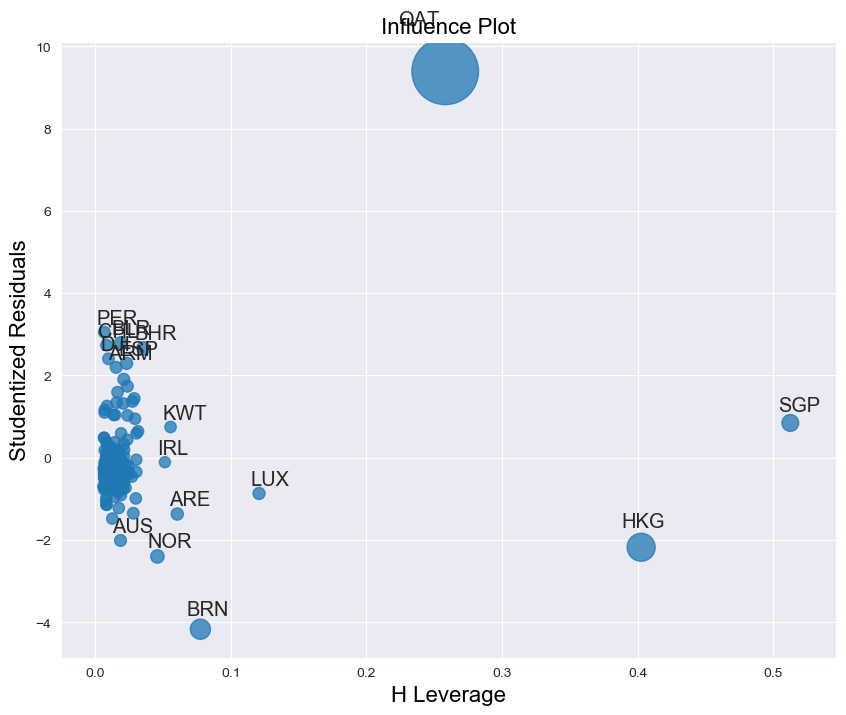

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sm.graphics.influence_plot(lm, ax=ax, criterion='cooks')
plt.show()

In [15]:
# 删除离群值QAT，因为其对模型产生了巨大的影响
covidanalysisminusoutliers = covidanalysis.loc[influence.cooks_d < 0.5]
lm = getlm(covidanalysisminusoutliers)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_cases_pm   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     46.56
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           5.52e-22
Time:                        12:00:41   Log-Likelihood:                -1464.8
No. Observations:                 173   AIC:                             2938.
Df Residuals:                     169   BIC:                             2950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.0854    349.924      0.126      0.900    -646.700     734.870
pop_density        0.2423      0.145      1.666      0.098      -0.045       0.529
median_age        -2.5165     13.526     -0.186      0.853     -29.217      24.184
gdp_per_capita     0.0557      0.007      7.875      0.000       0.042       0.070
==============================================================================
Omnibus:                       53.262   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.935
Skew:                           1.347   Prob(JB):                     1.22e-27
Kurtosis:                       6.152   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# k 最近邻算法
import pandas as pd
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler
covidtotals = pd.read_csv('C:\dataClean\Python-Data-Cleaning-Cookbook\Chapter04\data\covidtotals.csv')
covidtotals.set_index('iso_code', inplace=True)

In [18]:
standardizer = StandardScaler()
analysisvars = ['location', 'total_cases_pm', 'total_deaths_pm', 'pop_density', 'median_age', 'gdp_per_capita']
covidanalysis = covidtotals.loc[:, analysisvars].dropna()
covidanalysisstand = standardizer.fit_transform(covidanalysis.iloc[:, 1:])    # 标准化，使其转化为Z-score
covidanalysisstand

array([[-3.54798127e-01, -3.38797633e-01, -2.35023266e-01,
        -1.31297684e+00, -8.77010446e-01],
       [-3.52648607e-01, -2.96326476e-01, -1.73503538e-01,
         8.20846220e-01, -3.67279351e-01],
       [-4.38967308e-01, -2.66435163e-01, -2.80232931e-01,
        -1.58072607e-01, -2.59699312e-01],
       [-5.39956580e-01, -3.95367641e-01, -2.72255329e-01,
        -1.51096042e+00, -6.72316136e-01],
       [-4.19369162e-01, -1.28990994e-01, -1.86658613e-02,
         1.71900032e-01,  1.26550715e-01],
       [-3.63403844e-01, -2.92319434e-01, -2.81660900e-01,
         1.49901856e-01, -3.79660789e-03],
       [ 9.53717076e-01, -1.04995233e-02, -1.75869259e-01,
         5.67867197e-01, -5.21015202e-01],
       [-8.97327865e-02, -1.51130121e-01,  4.11742979e-01,
         1.17281703e+00,  8.64827050e-01],
       [-4.06546491e-01, -3.61172468e-01, -2.97483185e-01,
         8.09847132e-01,  1.30703974e+00],
       [ 3.40649943e-01,  2.51058198e-01, -1.71213422e-01,
         1.52478785e+00

In [21]:
clf_name = 'KNN'
clf = KNN(contamination=0.1)
clf.fit(covidanalysisstand)
KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest', metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)
y_pred = clf.labels_
y_scores = clf.decision_scores_

In [22]:
pred = pd.DataFrame(zip(y_pred, y_scores), columns=['outlier', 'scores'], index=covidanalysis.index)

In [23]:
pred.sample(10, random_state=1)

,outlier,scores
iso_code,,
LBY,0,0.367532
NLD,1,1.564052
BTN,0,0.185273
HTI,0,0.433058
EST,0,0.464279
LCA,0,0.431069
PER,0,1.411336
BRB,0,0.769047
MDA,0,0.912486


In [24]:
pred.outlier.value_counts()

0    157
1     18
Name: outlier, dtype: int64

In [25]:
pred.groupby(['outlier'])[['scores']].agg(['min', 'median', 'max'])

scores                    
              min    median       max
outlier                              
0        0.081259  0.364803  1.519804
1        1.553681  2.096079  9.483549

In [26]:
# 合并两个DataFrame
covidanalysis.join(pred).loc[pred.outlier==1, ['location', 'total_cases_pm', 'total_deaths_pm', 'scores']].sort_values(['scores'], ascending=False)

,location,total_cases_pm,total_deaths_pm,scores
iso_code,,,,
SGP,Singapore,5962.727,3.931,9.483549
QAT,Qatar,19753.146,13.190,8.001605
HKG,Hong Kong,0.000,0.000,7.771722
BEL,Belgium,5037.354,816.852,3.544827
BHR,Bahrain,6698.468,11.166,2.842906
LUX,Luxembourg,6418.776,175.726,2.442886
ESP,Spain,5120.952,580.197,2.176441
KWT,Kuwait,6332.420,49.642,2.127519
GBR,United Kingdom,4047.403,566.965,2.103458
